In [0]:
!pip install --upgrade -q gspread
!pip install --upgrade -q plotly
!pip install --upgrade -q sklearn


In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials


gc = gspread.authorize(GoogleCredentials.get_application_default())

# ***Import Data From Google Sheets***

In [0]:
# Open our new sheet and read some data.
worksheet = gc.open('Fire V2').sheet1

# get_all_values gives a list of rows.
#rows = worksheet.get_all_values()
rows = worksheet.get_all_records()
#print(rows)

# Convert to a DataFrame and render.
#pd.DataFrame.from_records(rows)
#investment_df = pd.DataFrame.from_records(rows)
#print(rows.tail(5))

# ***Import Libraries***

In [124]:
import calendar
import plotly
import skimage
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as colors
import seaborn as sns
import pandas as pd
import numpy as np
import statistics
from scipy import stats
from datetime import timedelta

np.set_printoptions(precision=3)

now = datetime.datetime.now()
year0 = now.year
month0 = now.month

year1 = now.year - 1
year2 = now.year - 2


#print(year0, month0)

first_of_month = str(now.year) +'-'+ str(now.month) +'-01'
print(first_of_month)
#plotly.__version_

2018-12-01


# ***Random Functions***

In [0]:
#Create function to create dummy data for past or future missing investment dates
#this will help heatmap and graphs look better.
def CreateMissingInvestmentDates(missing_investment_df, missing_type='past'):
  #Creating blank dataframe for missing investments dates
  investment_df =  pd.DataFrame([['place holder', 'place holder', '1985-01-01',0.00,0.00,0.00,0]],
                            columns=['company','type','first_of_month','begin_balance','end_balance','contributions','asset'])

  
  #creating first of year per past missing investment dates
  missing = int(len(missing_investment_df))
  for x in range(0, missing):
    missing_investment_df['begin_year'] = missing_investment_df['first_of_month'].astype(str).str[:4] + '-01-01'
    missing_investment_df['begin_year'] = pd.to_datetime(missing_investment_df['begin_year'], format='%Y-%m-%d')  
    missing_investment_df['end_year']   = missing_investment_df['first_of_month'].astype(str).str[:4] + '-12-31'
    missing_investment_df['end_year']   = pd.to_datetime(missing_investment_df['end_year'], format='%Y-%m-%d')  
  
  for x in range(0,missing):
      company       = missing_investment_df['company'][x]
      company_type  = missing_investment_df['type'][x]
      #differnt date range if its in the past or future.
      if missing_type == 'past':
        start         = missing_investment_df['begin_year'][x]
        end           = missing_investment_df['first_of_month'][x]
        date_range    = pd.date_range(start=start, end=end, freq='MS', closed='left')
      else:
        start         = missing_investment_df['first_of_month'][x]
        end           = missing_investment_df['end_year'][x]
        date_range    = pd.date_range(start=start, end=end, freq='MS', closed='right')        
      df            = pd.DataFrame(date_range, columns=['first_of_month'])
      df['company'] = company
      df['type']    = company_type
      df['first_of_month']   = pd.to_datetime(df['first_of_month'], format='%Y-%m-%d')
      investment_df = investment_df.append(df)
 
  #converting NA to 0 for balances
  investment_df['begin_balance'] = investment_df.begin_balance.fillna(0)
  investment_df['end_balance']   = investment_df.end_balance.fillna(0)
  investment_df['contributions'] = investment_df.contributions.fillna(0)
  investment_df['asset']         = investment_df.asset.fillna(0)
  #returning df in the function
  return investment_df

#Create Heatmap for bothly monthly and yearly data sets.
def CreateHeatMap(values_df, title = 'MTD ROR Title',agg='monthly'):
  ###########Creating Investment Name and Investment ID############
  #investment name
  values_df = values_df.assign(investment_name = values_df.company.astype(str) + ' - ' + values_df.type.astype(str))
  values_df = values_df.assign(balance_difference = values_df.end_balance - values_df.begin_balance - values_df.contributions)
  #investment ID
  investment_names_df = pd.DataFrame(values_df.investment_name.unique(),columns=['investment_name'])
  investment_names_df['investment_id'] = investment_names_df.index #+1
  #Joing both data frames
  #adding index
  values_df.set_index(['investment_name'],inplace=True )
  investment_names_df.set_index(['investment_name'],inplace=True)
  values_df = values_df.join([investment_names_df])
  #removing index
  values_df.reset_index(inplace =True)

  #random variables
  if agg=='monthly':
    month_num        = values_df.tran_month.unique()
    month_name       = values_df.tran_month_name.unique()
    month_num.sort(axis=0)
    column           = int(max(month_num))
    xlabels          = month_name
  elif agg=='yearly':
    year_num        = values_df.tran_year.unique()
    year_name       = values_df.tran_year.unique()
    year_num.sort(axis=0)
    year_name.sort(axis=0)
    column          = int(len(year_num))
    xlabels         = year_name
    
  investment_num   = values_df.investment_id.unique()
  investment_names = values_df.investment_name.unique()
  
  #row and columns of array 
  row = int(max(investment_num))
  
  #making a blank array 
  heat_map_array = np.zeros([row+1,column], dtype="float64")
  
  #loop through data to put rate of return in the array to figure out row level coloring.
  for x in range(row,-1,-1):
    c_investment = investment_num[x]
    for y in range(0,column):
      if agg=='monthly':
        c_month = month_num[y]
        ror_values     = values_df[(values_df.investment_id == c_investment)&(values_df.tran_month == c_month)].mror
        bal_diff_values = values_df[(values_df.investment_id == c_investment)&(values_df.tran_month == c_month)].balance_difference
      elif agg=='yearly':
        c_year = year_num[y]
        ror_values     = values_df[(values_df.investment_id == c_investment)&(values_df.tran_year == c_year)].yror
        bal_diff_values = values_df[(values_df.investment_id == c_investment)&(values_df.tran_year == c_year)].balance_difference
       
      
      #print(x,y,ror_values)
      '''
      if not(bal_diff_values.empty):
        bal_diff_values=np.round(bal_diff_values.item(),decimals=3)
      else:
        bal_diff_values = np.round(0.000, decimals=3)
      heat_map_array[x,y] = bal_diff_values #updating grid with current ROR 
      '''
      if not(ror_values.empty):
        ror_values=np.round(ror_values.item(),decimals=3)
      else:
        ror_values = np.round(0.000, decimals=3)
      heat_map_array[x,y] = ror_values #updating grid with current ROR 
      
      
      
  #move arrary to df to do row level coloring
  heat_map_df = pd.DataFrame(heat_map_array)
  #print(heat_map_df)
  #row_color_df = heat_map_df.div(heat_map_df.max(axis=1), axis=0) #enable row coloring
  #row_color_df = stats.zscore(heat_map_df)
  row_color_df = heat_map_df.div(heat_map_df.max(axis=1).where(heat_map_df.max(axis=1)!=0,abs(heat_map_df.min(axis=1)) ), axis=0)
  #print(row_color_df)
  #making the size of boxes    
  plt.figure(figsize=(18, 5))
  
  #Create heat map
  ax = sns.heatmap(row_color_df, fmt='', linewidth=0.2,  robust=True, square=False, xticklabels=xlabels, yticklabels=investment_names, cmap="PiYG")
  ax.set_title(title)
  
  #looping through dataframe to create the labels (annontate on the heat map)
  for x in range(row,-1,-1):
    x_plot = abs(x - 3)  #rows in dataframe and heat map arrary are inverse so have to sub by the number of investments
    #print(x_plot)
    c_investment = investment_num[x]
    for y in range(0,column):
      if agg=='monthly':
        c_month = month_num[y]
        ror_values     = values_df[(values_df.investment_id == c_investment)&(values_df.tran_month == c_month)].mror
        bal_diff_values = values_df[(values_df.investment_id == c_investment)&(values_df.tran_month == c_month)].balance_difference
      elif agg=='yearly':
        c_year = year_num[y]
        ror_values     = values_df[(values_df.investment_id == c_investment)&(values_df.tran_year == c_year)].yror
        bal_diff_values = values_df[(values_df.investment_id == c_investment)&(values_df.tran_year == c_year)].balance_difference
      
      #c_month = month_num[y]
      #mror_values     = values_df[(values_df.investment_id == c_investment)&(values_df.tran_month == c_month)].mror
      
      y_plot = y
      
      if bal_diff_values.empty:
        format_bal_diff = "$"+str(float(0.00)) 
      else:
        format_bal_diff = "${0:,.2f}".format(float(bal_diff_values.values))
      
      if ror_values.empty:
        format_ror_values = str(float(0.00))+"%"
      else:
        format_ror_values = "%.2f%%" % (ror_values)
      
      #Create label string
      annotation_string = str(format_ror_values)#r"%.2f%%" % (ror_values) 
      annotation_string += "\n"
      annotation_string += str(format_bal_diff)
      plt.annotate(annotation_string, xy=(y_plot+.15,x_plot+.25),color='black')
    

  plt.show()
  

# **Transform The Data**

In [0]:
#droping the dataframe
#investment_df.drop

#Initliazting the dataframe
investment_df = pd.DataFrame.from_records(rows)
#print(investment_df.tail(5))#just outputting the last 5 rows imported

################################################################################
'''
        Logic for misssing dates either past or future
        helps with graphs look pretty as well as heatmap
'''
  #grabbing min and max dates per investment
min_investment_dates = investment_df.groupby(['company','type'],as_index=False)['first_of_month'].min()
max_investment_dates = investment_df.groupby(['company','type'],as_index=False)['first_of_month'].max()
  #converting first_of_month to datetime format 
min_investment_dates['first_of_month'] = pd.to_datetime(min_investment_dates['first_of_month'], format='%Y-%m-%d')
max_investment_dates['first_of_month'] = pd.to_datetime(max_investment_dates['first_of_month'], format='%Y-%m-%d')

  #Creating blank dataframe for missing investments dates
missing_invesments_df =  pd.DataFrame([['place holder', 'place holder', '1985-01-01',0.00,0.00,0.00,0]],
                                columns=['company','type','first_of_month','begin_balance','end_balance','contributions','asset'])

past_missing_df   = CreateMissingInvestmentDates(min_investment_dates, missing_type='past')
future_missing_df = CreateMissingInvestmentDates(max_investment_dates, missing_type='future')
investment_df = investment_df.append(past_missing_df)
investment_df = investment_df.append(future_missing_df)
################################################################################

################################################################################
'''
        Random Variables
'''
#convert date column to a datetime format
investment_df['first_of_month'] =  pd.to_datetime(investment_df['first_of_month'], format='%Y-%m-%d')

#setting up helper columns
investment_df['tran_year']       = pd.DatetimeIndex(investment_df.first_of_month).year
investment_df['tran_month']      = pd.DatetimeIndex(investment_df.first_of_month).month
investment_df['tran_month_name'] = investment_df['tran_month'].apply(lambda x: calendar.month_abbr[x])
investment_df['mror']            = np.round((((investment_df.end_balance - investment_df.begin_balance - investment_df.contributions)/(investment_df.end_balance - investment_df.contributions))*100),decimals=2)

#Update NaN values
investment_df['mror'] = investment_df.mror.fillna(0)

#Remove place holder rows
investment_df = investment_df[investment_df.tran_year != 1985]
################################################################################


################################################################################
'''
          Remove outliers
'''
    #would like to do this in a loop for each investment type rather than the entire portfolio
    #also would like to look at STD
#postive_median        = investment_df.loc[(investment_df['mror']>=0) &(investment_df['mror']<=30), 'mror'].median()
#investment_df["mror"] = np.where(investment_df["mror"] >30, postive_median,investment_df['mror'])
#negative_median       = investment_df.loc[(investment_df['mror']>=-30.0)&(investment_df['mror']<0), 'mror'].median()
#investment_df["mror"] = np.where(investment_df["mror"] <=-30.0, negative_median,investment_df['mror'])
################################################################################

#final re-ordering
investment_df = investment_df.sort_values(['company','type','tran_year','tran_month','asset'], ascending=True)


# ***Net Worth Data***

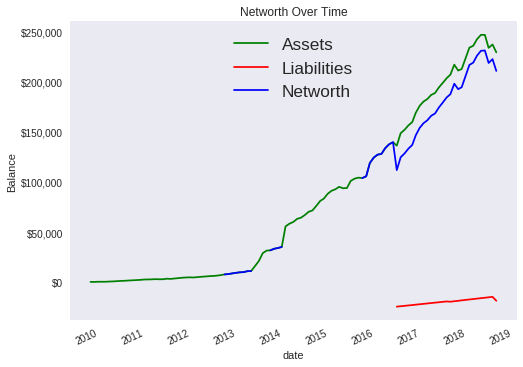

In [0]:

###################Assets and Liabilites########################################
assets_df      = investment_df[(investment_df.asset== 1)].groupby(['first_of_month'],as_index=False)['end_balance'].sum().sort_values('first_of_month')
liabilities_df = investment_df[(investment_df.asset== 0)].groupby(['first_of_month'],as_index=False)['end_balance'].sum().sort_values('first_of_month')

#####################Re-setting Indexes#########################################
assets_df.set_index(['first_of_month'],inplace=True )
liabilities_df.set_index(['first_of_month'],inplace=True )

####################Net Worth Dataframes########################################
networth_df = assets_df.join(liabilities_df,lsuffix='_assets', rsuffix='_liabilities')
networth_df.reset_index(inplace=True)
networth_df['networth'] = networth_df['end_balance_assets'] + networth_df['end_balance_liabilities']
#dropping both end_balance columns
#networth_df.drop(columns=['end_balance_assets', 'end_balance_liabilities'], axis=1)
networth_df.sort_values('first_of_month')
####################drop index##################################################
assets_df.reset_index(inplace =True)
liabilities_df.reset_index(inplace =True)
networth_df.reset_index(inplace =True)

###################Grabbing data points for lines###############################
x0 = assets_df[['first_of_month']]
y0 = assets_df[['end_balance']]
#function above will place 0.0 balance at begin of time;
#we want to exclude these records to see when debt has accord
x1 = liabilities_df[(liabilities_df.end_balance<0.0)][['first_of_month']]
y1 = liabilities_df[(liabilities_df.end_balance<0.0)][['end_balance']]

x2 = networth_df[['first_of_month']]
y2 = networth_df[['networth']]

##################Graphing out lines############################################
fig, ax = plt.subplots()
ax.plot(x0,y0, 'k', color = 'Green',label = 'Assets')
ax.plot(x1,y1, 'k', color = 'Red',  label = 'Liabilities')
ax.plot(x2,y2, 'k', color = 'Blue', label = 'Networth')

ax.set(xlabel='date', ylabel='Balance',title='Networth Over Time')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)


ax.grid()
#like to add annoates of life events.


### ***Current Year Monthly Rate of Return Comparing Investments***

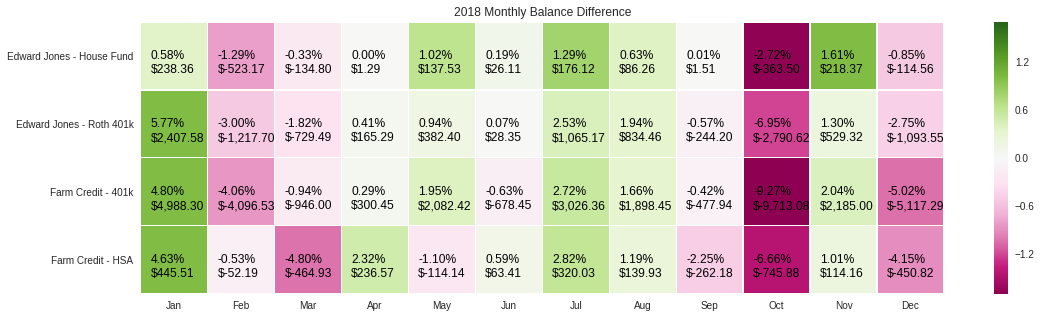

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

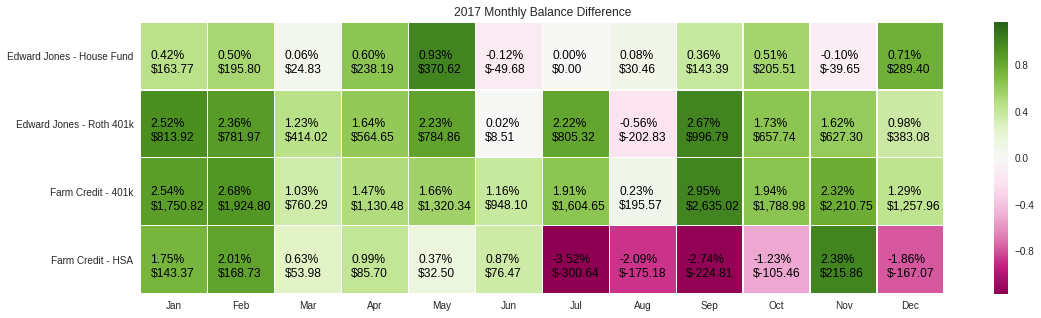

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

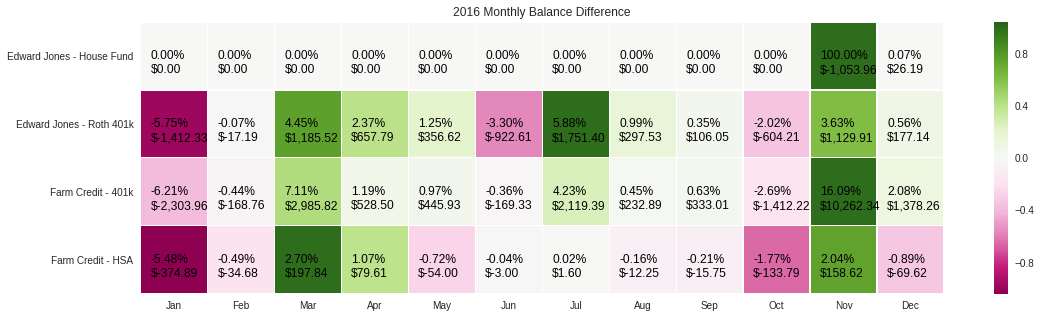

In [156]:
##########Current year Monthly Rate of Return DF#############################
current_year_monthly_investments = investment_df[(investment_df.company.isin(['Farm Credit','Edward Jones'])) & (investment_df.type.isin(['401k','HSA','Roth 401k','House Fund'])) &(investment_df.tran_year == now.year)][['first_of_month','company','type','tran_year','tran_month','tran_month_name','mror','begin_balance','end_balance','contributions']]
last_year_monthly_investments = investment_df[(investment_df.company.isin(['Farm Credit','Edward Jones'])) & (investment_df.type.isin(['401k','HSA','Roth 401k','House Fund'])) &(investment_df.tran_year == now.year-1)][['first_of_month','company','type','tran_year','tran_month','tran_month_name','mror','begin_balance','end_balance','contributions']]
two_years_ago_monthly_investments = investment_df[(investment_df.company.isin(['Farm Credit','Edward Jones'])) & (investment_df.type.isin(['401k','HSA','Roth 401k','House Fund'])) &(investment_df.tran_year == now.year-2)][['first_of_month','company','type','tran_year','tran_month','tran_month_name','mror','begin_balance','end_balance','contributions']]


CreateHeatMap(current_year_monthly_investments, title = str(now.year)+ ' Monthly Balance Difference',agg='monthly')
print("*"*1000)
CreateHeatMap(last_year_monthly_investments, title = str(now.year-1)+' Monthly Balance Difference',agg='monthly')
print("*"*1000)
CreateHeatMap(two_years_ago_monthly_investments, title = str(now.year-2) +' Monthly Balance Difference',agg='monthly')


#print(two_years_ago_monthly_investments.head(12))


# ***Yearly Rate of Return***


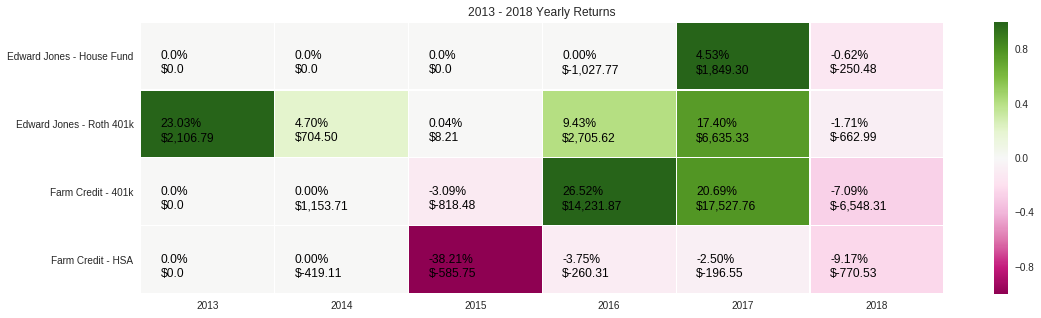

In [157]:
#########Past 5 Year Yearly ROR DF############################################
past_five_year_monthly_investments = investment_df[(investment_df.company.isin(['Farm Credit','Edward Jones']))
                                                   &(investment_df.type.isin(['401k','HSA','Roth 401k','House Fund'])) 
                                                   &(investment_df.tran_year >= now.year - 5)]
                                                  #[['first_of_month','company','type','tran_year','tran_month','tran_month_name','mror','begin_balance','end_balance','contributions']]

begin_balances_df = past_five_year_monthly_investments[(past_five_year_monthly_investments.tran_month==1)][['company','type','tran_year','begin_balance']]
end_balances_df   = past_five_year_monthly_investments[(past_five_year_monthly_investments.tran_month==12)][['company','type','tran_year','end_balance']]#add logic for when 2019 hits
contributions_df  = past_five_year_monthly_investments.groupby(['company','type', 'tran_year'],as_index=False)['contributions'].sum()
#set indexes
begin_balances_df.set_index(['company','type','tran_year'],inplace=True )
end_balances_df.set_index(['company','type','tran_year'],inplace=True )
contributions_df.set_index(['company','type','tran_year'],inplace=True )
#join df
past_five_df = begin_balances_df.join([end_balances_df,contributions_df])
past_five_df.reset_index(inplace =True)
#cal the ror
#past_five_df = past_five_df.assign(balance_difference = past_five_df.end_balance - past_five_df.begin_balance - past_five_df.contributions)
past_five_df['yror']  = np.round((((past_five_df.end_balance - past_five_df.begin_balance - past_five_df.contributions)/(past_five_df.end_balance - past_five_df.contributions))*100),decimals=2)
#remove outliers (if 100% change to 0)
#postive_median        = investment_df.loc[(investment_df['mror']>=0) &(investment_df['mror']<=30), 'mror'].median()
past_five_df['yror'] = np.where(past_five_df["yror"] == 100.00, 0.00,past_five_df['yror'])
CreateHeatMap(past_five_df, title = str(now.year-5) + " - " + str(now.year)+' Yearly Returns',agg='yearly')
################################################################################
#print(past_five_df.head(15))


# ***Investment Type Balances Over Time***

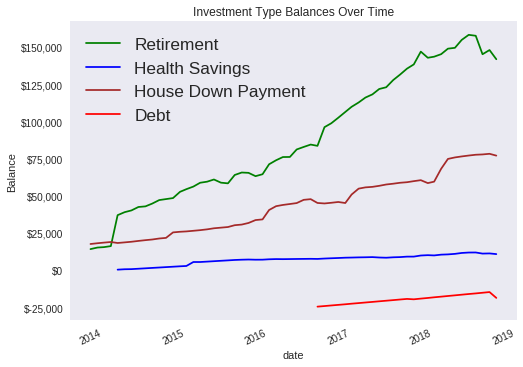

In [158]:
current_year  = now.year
current_month = now.month
balances_df = investment_df[(investment_df.tran_year <= current_year) & (investment_df.tran_month <= current_month)&(investment_df.tran_year>=2014)][['company', 'type', 'first_of_month','end_balance','asset']]
#######################Groupings################################################
#balances_df.loc[ balances_df.type == 'HCSP', 'groupings' ] = 'Health Savings'
balances_df.loc[ balances_df.type.isin(['401k', 'Roth 401k','Deferred Comp Plan']),'groupings'] = 'Retirement'
balances_df.loc[ balances_df.type.isin(['HCSP', 'HSA']),'groupings'] = 'HSA'
balances_df.loc[ balances_df.type.isin(['House Fund' ]),'groupings'] = 'House'
balances_df.loc[ balances_df.asset.isin([0]),'groupings'] = 'Debt'

################################################################################

#######################Summing Groupings########################################
balances_summed_df = balances_df.groupby(['groupings', 'first_of_month'], as_index=False).sum()
################################################################################


###################Grabbing data points for lines###############################
retirement_df = balances_summed_df[(balances_summed_df.groupings == 'Retirement')][['first_of_month','end_balance']]
x0 = retirement_df[['first_of_month']]
y0 = retirement_df[['end_balance']]

health_savings_df = balances_summed_df[(balances_summed_df.groupings == 'HSA')][['first_of_month','end_balance']]
x1 = health_savings_df[['first_of_month']]
y1 = health_savings_df[['end_balance']]

house_downpayment_df = balances_summed_df[(balances_summed_df.groupings == 'House')][['first_of_month','end_balance']]
x2 = house_downpayment_df[['first_of_month']]
y2 = house_downpayment_df[['end_balance']]

debt_df = balances_summed_df[(balances_summed_df.groupings == 'Debt')][['first_of_month','end_balance']]
x3 = debt_df[(debt_df.end_balance<0.0)][['first_of_month']]
y3 = debt_df[(debt_df.end_balance<0.0)][['end_balance']]

##################Graphing out lines############################################
fig, ax = plt.subplots()
ax.plot(x0,y0, 'k', color = 'Green',label = 'Retirement')
ax.plot(x1,y1, 'k', color = 'Blue', label = 'Health Savings')
ax.plot(x2,y2, 'k', color = 'Brown',label = 'House Down Payment')
ax.plot(x3,y3, 'k', color = 'Red',  label = 'Debt')


ax.set(xlabel='date', ylabel='Balance',title='Investment Type Balances Over Time')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
ax.grid()

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

plt.show()

################################################################################